In [1]:
import anndata as ad
import scanpy as sc

In [2]:
import pandas as pd

In [3]:
from matplotlib.pyplot import rc_context

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt


### Get phenotype scores

In [4]:
Ci_adata = ad.read_h5ad('datasets/CRISPRi.h5ad')
Ca_A549_adata = ad.read_h5ad('datasets/CRISPRa_A549.h5ad')
Ca_k562_adata = ad.read_h5ad('datasets/CRISPRa_k562.h5ad')

In [5]:
rename_comparisons = {
    'PARPi':'rho1',
    'DNAPKi':'rho2',
    'ATMi':'rho3',
    'ATRi':'rho4',
    'WEE1i':'rho5',
    'PARPi+DNAPKi':'rho6',
    'PARPi+ATMi':'rho7',
    'PARPi+ATRi':'rho8',
    'PARPi+WEE1i':'rho9'
}

In [55]:
Ci_pdata = ad.AnnData(
    X = Ci_adata.obsm['phenotypes'].T,
    var = Ci_adata.obs
)

for k,v in rename_comparisons.items():
    Ci_pdata.obs.index = Ci_pdata.obs.index.str.replace(v,k)


Ci_pdata = Ci_pdata[:,Ci_pdata.to_df().isna().sum(axis=0).eq(0)]
Ci_pdata.obs = pd.DataFrame(list(Ci_pdata.obs.index.str.split(' ')), columns = ['score','replicate'],index=Ci_pdata.obs.index,dtype=str)
Ci_pdata.obs.score = pd.Categorical(
    Ci_pdata.obs.score,
    categories=['gamma',
                'PARPi',
                'DNAPKi',
                'PARPi+DNAPKi',
                'ATMi',
                'PARPi+ATMi',
                'ATRi',
                'PARPi+ATRi',
                'WEE1i',
                'PARPi+WEE1i'
               ]
)

Ci_pdata

AnnData object with n_obs × n_vars = 30 × 97228
    obs: 'score', 'replicate'
    var: 'sublibrary', 'gene', 'transcripts', 'sequence'

In [ ]:
Ci_pdata = ad.AnnData(
    X = Ci_adata.obsm['phenotypes'].T,
    var = Ci_adata.obs
)


In [57]:
Ci_pdata.write_h5ad('datasets/CRISPRi_phenotypes.h5ad')

only keep `ave` scores:

In [26]:
Ci_pdata_ave = Ci_pdata[Ci_pdata.obs.index.str.contains('ave'),].copy()

### PCA

In [27]:
sc.tl.pca(Ci_pdata_ave, svd_solver='arpack')

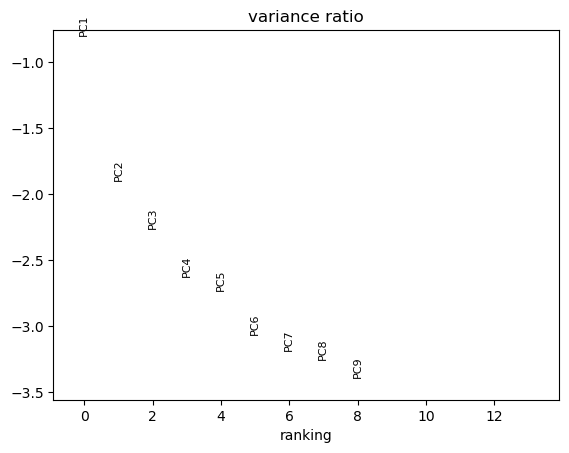

In [28]:
sc.pl.pca_variance_ratio(Ci_pdata_ave, log=True, n_pcs=13) # scanpy generates the filename automatically

In [29]:
Ci_pdata_ave.obs['treatment'] = 'ctrl'
Ci_pdata_ave.obs.loc[Ci_pdata_ave.obs.score.str.contains('i'),'treatment'] = 'mono'
Ci_pdata_ave.obs.loc[Ci_pdata_ave.obs.score.str.contains('i\+'),'treatment'] = 'combo'
Ci_pdata_ave.obs['treatment'] = pd.Categorical(Ci_pdata_ave.obs['treatment'],categories=['ctrl','mono','combo'])

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


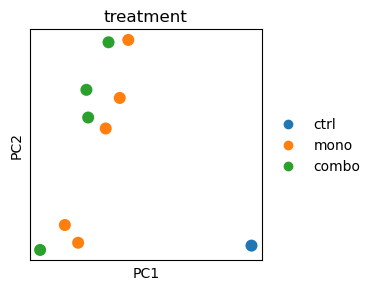

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


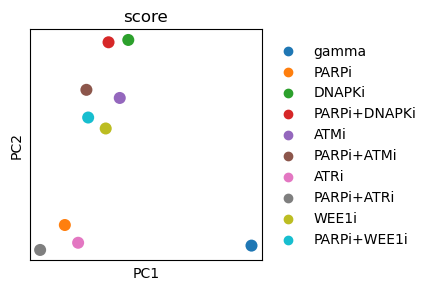

In [30]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        Ci_pdata_ave,
        size=300,
        color=['treatment'],
    )  # plot the pca results with color as mouse.id 
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.pca(
        Ci_pdata_ave,
        size=300,
        color=['score'],
    )  # plot the pca results with color as mouse.id 

### PCA (2)

let's skip `gamma` and redo the PCA

In [31]:
Ci_pdata_ave_rho = Ci_pdata_ave[~Ci_pdata_ave.obs.score.eq('gamma'),:].copy()

In [32]:
sc.tl.pca(Ci_pdata_ave_rho, svd_solver='arpack')

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


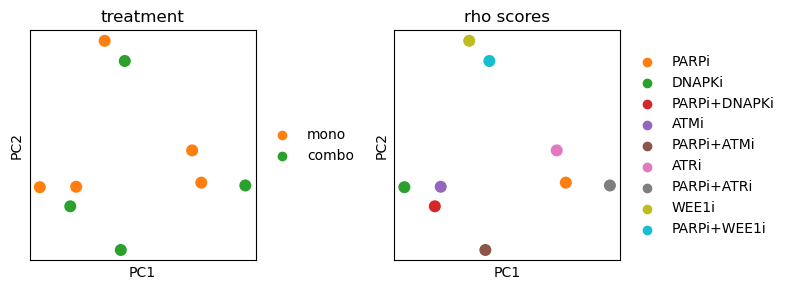

In [112]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (8, 3))

sc.pl.pca(
    Ci_pdata_ave_rho,
    size=300,
    color=['treatment'],
    show=False,
    ax=ax1
) 

sc.pl.pca(
    Ci_pdata_ave_rho,
    size=300,
    color=['score'],
    title = 'rho scores',
    show=False,
    ax=ax2
)  

plt.tight_layout()
plt.savefig('PCA_plots.pdf')
plt.show()

### Correlation plot

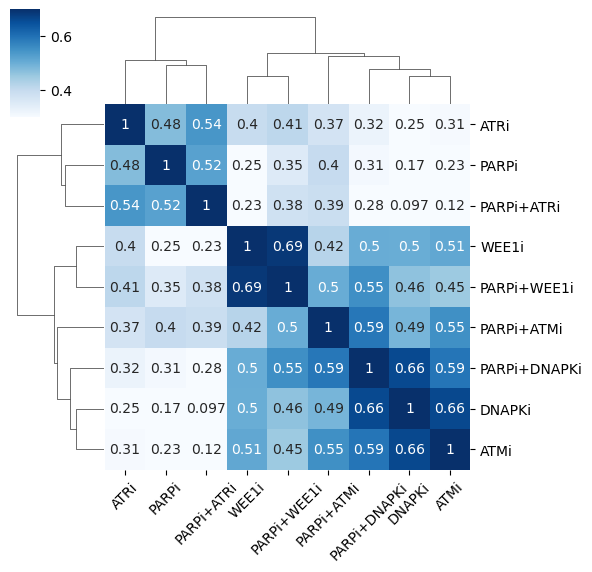

In [109]:
df = Ci_pdata_ave_rho.to_df().T
df.columns = df.columns.str.split(' ').str[0]
g = sns.clustermap(df.corr(), 
                   method = 'complete', 
                   # cmap   = 'rocket_r', 
                   cmap    = 'Blues', 
                   annot   = True, 
                   vmin    = 0.3,
                   vmax    = 0.7,
                   annot_kws = {'size': 10},
                   figsize=(6, 6)
                  )
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45);

In [111]:
df.corr().to_csv('corr.csv')

In [ ]:
df

# 

In [113]:
from watermark import watermark
print(
    watermark()
)
print('_'*80)
print(
    watermark(iversions=True, globals_=globals())
)

Last updated: 2023-07-17T14:51:21.932694-07:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

________________________________________________________________________________
seaborn   : 0.12.2
matplotlib: 3.7.2
anndata   : 0.9.1
scanpy    : 1.9.3
pandas    : 2.0.3

